In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error
import pickle

import mlflow


import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope



In [24]:
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/03_experiment_tracking/mlruns/1', creation_time=1737041915913, experiment_id='1', last_update_time=1737041915913, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [4]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    df[categorical] = df[categorical].astype(str)
    return df

In [5]:
train_path = "./data/green_tripdata_2021-01.parquet"
valid_path = "./data/green_tripdata_2021-02.parquet"
df_train = read_dataframe(train_path)
df_valid =  read_dataframe(valid_path)

In [6]:
len(df_train), len(df_valid)

(73908, 61921)

In [7]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_valid['PU_DO'] = df_valid['PULocationID'] + '_' + df_valid['DOLocationID']

In [8]:
categorical = ['PU_DO']

In [9]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_valid[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_valid = df_valid[target].values

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_valid, y_pred)


7.758715200888857

In [11]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

/tmp/ipykernel_2209/2256765719.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2209/2256765719.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_valid, label='actual')


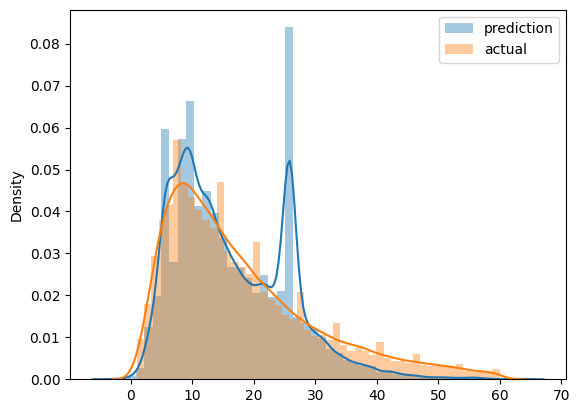

In [12]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_valid, label='actual')

plt.legend()

In [13]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_valid, y_pred)

9.233436225720547

In [14]:
lr = Ridge(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_valid, y_pred)

7.520393154812667

### MlFlow 

In [15]:
with mlflow.start_run():

    mlflow.set_tag("developer", "anubhav")
    mlflow.log_param("train-data-path", train_path)
    mlflow.log_param("valid-data-path", valid_path)

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_valid, y_pred)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")


### Hyperopt

In [16]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_valid)

In [20]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals = [(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_valid, y_pred)
        mlflow.log_metric("rmse", rmse)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [21]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0), # exp(-3), exp(0) - [0.05, 1]
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": "reg:linear",
    "seed": 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals = 5, 
    trials = Trials())

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.33476                         
[1]	validation-rmse:10.57778                         
[2]	validation-rmse:9.93141                          
[3]	validation-rmse:9.38053                          
[4]	validation-rmse:8.91171                          
[5]	validation-rmse:8.51634                          
[6]	validation-rmse:8.18355                          
[7]	validation-rmse:7.90470                          
[8]	validation-rmse:7.67250                          
[9]	validation-rmse:7.47697                          
[10]	validation-rmse:7.31342                         
[11]	validation-rmse:7.17960                         
[12]	validation-rmse:7.06616                         
[13]	validation-rmse:6.97211                         
[14]	validation-rmse:6.89389                         
[15]	validation-rmse:6.82782                         
[16]	validation-rmse:6.77246                         
[17]	validation-rmse:6.72604                         
[18]	validation-rmse:6.68707

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.67843                                                    
[1]	validation-rmse:7.30571                                                    
[2]	validation-rmse:6.81281                                                    
[3]	validation-rmse:6.62719                                                    
[4]	validation-rmse:6.53930                                                    
[5]	validation-rmse:6.50152                                                    
[6]	validation-rmse:6.48216                                                    
[7]	validation-rmse:6.46853                                                    
[8]	validation-rmse:6.45565                                                    
[9]	validation-rmse:6.45008                                                    
[10]	validation-rmse:6.44648                                                   
[11]	validation-rmse:6.44510                                                   
[12]	validation-rmse:6.43888            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.19499                                                   
[1]	validation-rmse:7.80212                                                   
[2]	validation-rmse:7.19741                                                   
[3]	validation-rmse:6.93992                                                   
[4]	validation-rmse:6.81862                                                   
[5]	validation-rmse:6.75604                                                   
[6]	validation-rmse:6.72441                                                   
[7]	validation-rmse:6.70587                                                   
[8]	validation-rmse:6.68555                                                   
[9]	validation-rmse:6.67813                                                   
[10]	validation-rmse:6.67162                                                  
[11]	validation-rmse:6.66780                                                  
[12]	validation-rmse:6.66592                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.16490                                                   
[3]	validation-rmse:6.92689                                                   
[4]	validation-rmse:6.82149                                                   
[5]	validation-rmse:6.77274                                                   
[6]	validation-rmse:6.74501                                                   
[7]	validation-rmse:6.72846                                                   
[8]	validation-rmse:6.72026                                                   
[9]	validation-rmse:6.71643                                                   
[10]	validation-rmse:6.71271                                                  
[11]	validation-rmse:6.70926                                                  
[12]	validation-rmse:6.70472                                                  
[13]	validation-rmse:6.70377                                                  
[14]	validation-rmse:6.69664                        

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:43:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.52315                                                   
[1]	validation-rmse:10.91206                                                   
[2]	validation-rmse:10.37235                                                   
[3]	validation-rmse:9.89734                                                    
[4]	validation-rmse:9.48065                                                    
[5]	validation-rmse:9.11616                                                    
[6]	validation-rmse:8.79835                                                    
[7]	validation-rmse:8.52201                                                    
[8]	validation-rmse:8.28249                                                    
[9]	validation-rmse:8.07507                                                    
[10]	validation-rmse:7.89587                                                   
[11]	validation-rmse:7.74126                                                   
[12]	validation-rmse:7.60816            

### Train XgBoost Model

In [17]:
mlflow.xgboost.autolog(log_input_examples=True, disable=True)

In [18]:
params = {'learning_rate': 0.20472169880371677,
          'max_depth': 17,
          'min_child_weight': 1.2402611720043835,
          'objective': 'reg:linear',
          'reg_alpha': 0.28567896734700793,
          'reg_lambda': 0.004264404814393109,
          'seed':42}


booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals = [(valid, "validation")],
            early_stopping_rounds=50
        )

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:55:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.62105
[1]	validation-rmse:9.45454
[2]	validation-rmse:8.61244
[3]	validation-rmse:8.02161
[4]	validation-rmse:7.60613
[5]	validation-rmse:7.31430
[6]	validation-rmse:7.11506
[7]	validation-rmse:6.97578
[8]	validation-rmse:6.87711
[9]	validation-rmse:6.80659
[10]	validation-rmse:6.75482
[11]	validation-rmse:6.71870
[12]	validation-rmse:6.68975
[13]	validation-rmse:6.67024
[14]	validation-rmse:6.65272
[15]	validation-rmse:6.63910
[16]	validation-rmse:6.62823
[17]	validation-rmse:6.62004
[18]	validation-rmse:6.61336
[19]	validation-rmse:6.60866
[20]	validation-rmse:6.60602
[21]	validation-rmse:6.60323
[22]	validation-rmse:6.60192
[23]	validation-rmse:6.60053
[24]	validation-rmse:6.59835
[25]	validation-rmse:6.59609
[26]	validation-rmse:6.59387
[27]	validation-rmse:6.59214
[28]	validation-rmse:6.59088
[29]	validation-rmse:6.58932
[30]	validation-rmse:6.58731
[31]	validation-rmse:6.58478
[32]	validation-rmse:6.58333
[33]	validation-rmse:6.58150
[34]	validation-rmse:6.

### Log XgBoost Model

In [19]:
with mlflow.start_run():
    best_params = {'learning_rate': 0.20472169880371677,
          'max_depth': 17,
          'min_child_weight': 1.2402611720043835,
          'objective': 'reg:linear',
          'reg_alpha': 0.28567896734700793,
          'reg_lambda': 0.004264404814393109,
          'seed':42}
    
    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_valid, y_pred)
    mlflow.log_metric("rmse", rmse)

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

    with open("models/preprocessor.b", "wb") as f_out: pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:57:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.62105
[1]	validation-rmse:9.45454
[2]	validation-rmse:8.61244
[3]	validation-rmse:8.02161
[4]	validation-rmse:7.60613
[5]	validation-rmse:7.31430
[6]	validation-rmse:7.11506
[7]	validation-rmse:6.97578
[8]	validation-rmse:6.87711
[9]	validation-rmse:6.80659
[10]	validation-rmse:6.75482
[11]	validation-rmse:6.71870
[12]	validation-rmse:6.68975
[13]	validation-rmse:6.67024
[14]	validation-rmse:6.65272
[15]	validation-rmse:6.63910
[16]	validation-rmse:6.62823
[17]	validation-rmse:6.62004
[18]	validation-rmse:6.61336
[19]	validation-rmse:6.60866
[20]	validation-rmse:6.60602
[21]	validation-rmse:6.60323
[22]	validation-rmse:6.60192
[23]	validation-rmse:6.60053
[24]	validation-rmse:6.59835
[25]	validation-rmse:6.59609
[26]	validation-rmse:6.59387
[27]	validation-rmse:6.59214
[28]	validation-rmse:6.59088
[29]	validation-rmse:6.58932
[30]	validation-rmse:6.58731
[31]	validation-rmse:6.58478
[32]	validation-rmse:6.58333
[33]	validation-rmse:6.58150
[34]	validation-rmse:6.

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:58:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/01/16 22:58:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Prediction with MlFlow model

In [20]:
logged_model = 'runs:/572cb54e33294bee9740e1736a7446ce/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [21]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 572cb54e33294bee9740e1736a7446ce

In [22]:
xgboost_model = mlflow.xgboost.load_model(logged_model); xgboost_model

In [23]:
y_pred = xgboost_model.predict(valid); y_pred[:10]

array([14.809331,  7.256571, 15.71568 , 24.437902,  9.105063, 17.193743,
       11.460967,  8.388062,  9.049488, 18.53353 ], dtype=float32)

### MLFlow Client

In [53]:
from mlflow.tracking import MlflowClient

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [55]:
client.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops-zoomcamp/03_experiment_tracking/mlruns/2', creation_time=1737072004796, experiment_id='2', last_update_time=1737072004796, lifecycle_stage='active', name='my-cool-experiment', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops-zoomcamp/03_experiment_tracking/mlruns/1', creation_time=1737041915913, experiment_id='1', last_update_time=1737041915913, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1736874266046, experiment_id='0', last_update_time=1736874266046, lifecycle_stage='active', name='Default', tags={}>]

In [27]:
client.create_experiment("my-cool-experiment")

'2'

In [56]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='1',
    filter_string="",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
)

In [57]:
for run in runs: print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: 8a25e4b8c96448978f2dbca0a9e38b36, rmse: 6.3136
run id: 572cb54e33294bee9740e1736a7446ce, rmse: 6.3136
run id: 07b09c4697614ade93400f3983502365, rmse: 6.3136
run id: 4a63f91c5e66412889825cc21be6bde4, rmse: 6.3136
run id: 3b6d0681bd974c0484e126b27a355eab, rmse: 6.3137


In [58]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [59]:
run_id = "8a25e4b8c96448978f2dbca0a9e38b36"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri=model_uri, name="nyc-taxi-regressor")

Registered model 'nyc-taxi-regressor' already exists. Creating a new version of this model...
Created version '5' of model 'nyc-taxi-regressor'.


<ModelVersion: aliases=[], creation_timestamp=1737077796199, current_stage='None', description=None, last_updated_timestamp=1737077796199, name='nyc-taxi-regressor', run_id='8a25e4b8c96448978f2dbca0a9e38b36', run_link=None, source='/workspaces/mlops-zoomcamp/03_experiment_tracking/mlruns/1/8a25e4b8c96448978f2dbca0a9e38b36/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=5>

In [60]:
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1737072838434, description='Model for NYC Taxi Trip Prediction', last_updated_timestamp=1737077796199, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1737077796199, current_stage='None', description=None, last_updated_timestamp=1737077796199, name='nyc-taxi-regressor', run_id='8a25e4b8c96448978f2dbca0a9e38b36', run_link=None, source='/workspaces/mlops-zoomcamp/03_experiment_tracking/mlruns/1/8a25e4b8c96448978f2dbca0a9e38b36/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=5>], name='nyc-taxi-regressor', tags={}>]

In [66]:
latest_versions = client.search_model_versions()
for version in latest_versions:
    print(f"version: {version.version}, name: {version.name}")

version: 5, name: nyc-taxi-regressor
version: 4, name: nyc-taxi-regressor
version: 3, name: nyc-taxi-regressor
version: 2, name: nyc-taxi-regressor
version: 1, name: nyc-taxi-regressor


In [70]:
from datetime import datetime 

date = datetime.today().date()
client.update_model_version(name="nyc-taxi-regressor",
                            version=4,
                            description=f"Model for NYC Taxi Ride Prediction registered on {date}")

<ModelVersion: aliases=[], creation_timestamp=1737073482754, current_stage='None', description='Model for NYC Taxi Ride Prediction registered on 2025-01-17', last_updated_timestamp=1737078373487, name='nyc-taxi-regressor', run_id='8a25e4b8c96448978f2dbca0a9e38b36', run_link=None, source='/workspaces/mlops-zoomcamp/03_experiment_tracking/mlruns/1/8a25e4b8c96448978f2dbca0a9e38b36/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=4>

In [72]:
client.get_model_version_by_alias(name="nyc-taxi-regressor", alias="production").version

3

In [75]:
from sklearn.metrics import root_mean_squared_error

def read_dataframe(filename):
    df = pd.read_csv(filename)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df


def preprocess(df, dv):
    df['PU_DO'] = df['PULocationID'] + '_' + df['DULocationID']
    categorical = ['PU_DO']
    numerical = ['trip_distance']
    train_dicts = df[categorical + numerical].to_dict(orient='records')
    return dv.transform(train_dicts)

def test_model(name, env, X_test, y_test):
    model = mlflow.pyfunc.load_model(f"models:/{name}@{env}")
    y_pred = model.predict(X_test)
    return {"rmse": root_mean_squared_error(y_test, y_pred)}